<a href="https://colab.research.google.com/github/WaznyKamo/CDR_Stock_Price_Prediction_Using_LSTM_Deep_Learning_Network/blob/main/CDR_Stock_Price_Prediction_Using_LSTM_Deep_Learning_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prediction of stock prices on example of CD PROJEKT RED

Daily data used in the notebook comes from: https://stooq.pl/q/d/?s=cdr
In order to load data one should download a file, load it into Google Drive and change the mounting point path

The program will ask for logging in into your google account in order to mount data from the Drive to Colab.


In [213]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [214]:
import pandas as pd
import numpy as np

daily_data = pd.read_csv("/content/drive/MyDrive/Praca magisterska/data/cdr_d.csv")

daily_data.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1994-08-02,8.2789,8.2789,8.2789,8.2789,347109.0
1,1994-08-03,9.0931,9.0931,9.0931,9.0931,325196.0
2,1994-08-04,9.9950,9.9950,9.9950,9.9950,355499.0
3,1994-08-08,9.0931,9.0931,9.0931,9.0931,263619.0
4,1994-08-09,10.7320,10.7320,10.7320,10.7320,135441.0


In [215]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556 entries, 0 to 6555
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        6556 non-null   object 
 1   Otwarcie    6556 non-null   float64
 2   Najwyzszy   6556 non-null   float64
 3   Najnizszy   6556 non-null   float64
 4   Zamkniecie  6556 non-null   float64
 5   Wolumen     6555 non-null   float64
dtypes: float64(5), object(1)
memory usage: 307.4+ KB


In [216]:
null_columns = daily_data.columns[daily_data.isnull().any()]
daily_data.isnull().sum()

Data          0
Otwarcie      0
Najwyzszy     0
Najnizszy     0
Zamkniecie    0
Wolumen       1
dtype: int64

In [217]:
## Droping last 100 rows to check if the NN would perform better
daily_data = daily_data.iloc[:-100]

In [218]:
daily_data['Data'] = pd.to_datetime(daily_data.Data)

In [219]:
print(daily_data[daily_data["Wolumen"].isnull()]) # row with a null value

         Data  Otwarcie  Najwyzszy  Najnizszy  Zamkniecie  Wolumen
79 1994-12-08    5.1204     5.1204     5.1204      5.1204      NaN


In given dataset on 1994-12-08 the Wolumen value is null. According to https://www.biznesradar.pl/notowania-historyczne/CD-PROJEKT,130 it should be 0, so the value has to be overwritten.



In [220]:
daily_data.fillna(0, inplace=True)
print(daily_data[daily_data["Wolumen"].isnull()])

Empty DataFrame
Columns: [Data, Otwarcie, Najwyzszy, Najnizszy, Zamkniecie, Wolumen]
Index: []


In [221]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=daily_data['Data'],
                                     open=daily_data['Otwarcie'],
                                     high=daily_data['Najwyzszy'],
                                     low=daily_data['Najnizszy'],
                                     close=daily_data['Zamkniecie'])])

fig.update_layout(title='Stock price of CD Projekt',
                  yaxis_title='Price',
                  xaxis_title='Date')
fig.show()

# slider below the plot can be used for narrowing the dates

# Preparation of data for prediction



In [222]:
from sklearn.preprocessing import MinMaxScaler

# expected input data shape [number of training examples, number of data in single example (days considered for prediction), number of features]
def preprocess_scaled_data(data):
  list_of_features = []
  for column in data.columns:
    list_of_features.append(data[column])

  dataset = np.transpose(list_of_features)

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)

  return scaled_data, scaler


In [223]:
dataset, scaler = preprocess_scaled_data(daily_data.drop(columns=['Data']))
print('dataset shape: ' + str(dataset.shape))

# using data from last 30 days for validation, rest for training
training_data = dataset[:-30,:]

x_train = []
y_train = []
x_valid = []
y_valid = []

# predicting prices from data from last 60 days
for i in range(60, training_data.shape[0]):
  x_train.append(training_data[i-60:i, :])
  y_train.append(training_data[i,:])

x_train, y_train = np.array(x_train), np.array(y_train)

print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))

for i in range(dataset.shape[0] - 30, dataset.shape[0]):
  x_valid.append(dataset[i-60:i, :])
  y_valid.append(dataset[i,:])

x_valid, y_valid = np.array(x_valid), np.array(y_valid)

print('x_valid shape: ' + str(x_valid.shape))
print('y_valid shape: ' + str(y_valid.shape))

dataset shape: (6456, 5)
x_train shape: (6366, 60, 5)
y_train shape: (6366, 5)
x_valid shape: (30, 60, 5)
y_valid shape: (30, 5)


## Defining the LSTM Model

In [224]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Lambda, Dropout, Conv1D
import matplotlib.pyplot as plt

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 55        
Total params: 18,625
Trainable params: 18,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
199/199 [==============================] - 3s 7ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 2/30
199/199 [==============================] - 1s 4ms/step - loss: 4.4427e-04 - val_loss: 0.0015
Epoch 3/30
199/199 [==============================] - 1s 4ms/step - loss: 3.5366e-04 - val_loss: 9.0958e-04
Epoch 4/30
199/199 [==============================] - 1s 5ms/step -

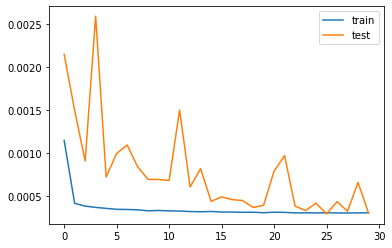

In [225]:

model = Sequential()
model.add(LSTM(64, input_shape=[x_train.shape[1], x_train.shape[2]])) #), return_sequences=True))
#model.add(LSTM(64))
#model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Dense(x_train.shape[2]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [226]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model.  Made on the last 30 days of the stock data

predictions = model.predict(x_valid)
predictions = scaler.inverse_transform(predictions)

mae = np.mean(np.abs((predictions[:,1] - scaler.inverse_transform(y_valid)[:,1])))
naive_forcast_difference = [abs(scaler.inverse_transform(y_valid)[i + 1,1] - scaler.inverse_transform(y_valid)[i,1]) for i in range(y_valid.shape[0] - 1)]
naive_forcast_mae = sum(naive_forcast_difference) / len(naive_forcast_difference)

mape = np.mean((np.abs((predictions[:,1] - scaler.inverse_transform(y_valid)[:,1]))/scaler.inverse_transform(y_valid)[:,1])*100)
naive_forcast_mape = (naive_forcast_mae/scaler.inverse_transform(y_valid)[:,1].mean()) * 100


print('Prediction mean absolute error: ' + str(mae))
print('Naive forcast mean absolute error: ' + str(naive_forcast_mae))

print('Prediction mean absolute percentage error: ' + str(mape))
print('Naive forcast mean absolute percentage error: ' + str(naive_forcast_mape))


Prediction mean absolute error: 5.7883760579427115
Naive forcast mean absolute error: 6.4999999999999964
Prediction mean absolute percentage error: 1.4556887780435739
Naive forcast mean absolute percentage error: 1.6250270837847292


In [227]:
# Comparision of the closing stock prices
inversed_dataset = scaler.inverse_transform(dataset)
print('Closing prices: Predicted/Real/Difference/Percentage difference')
closing_prices = daily_data['Zamkniecie']

for i in range(predictions.shape[0]):
  difference = round(predictions[i, 1] - daily_data['Zamkniecie'].iloc[-30 + i], 1)
  diff_percent = (difference/daily_data['Zamkniecie'].iloc[-30 + i]) * 100

  print(str(round(predictions[i, 1], 1)) + ' / ' + str(daily_data['Zamkniecie'].iloc[-30 + i]) + ' / ' + str(difference) + ' / ' + str(round(diff_percent,2)) + '%')

Closing prices: Predicted/Real/Difference/Percentage difference
409.1 / 401.6 / 7.5 / 1.87%
404.5 / 394.9 / 9.6 / 2.43%
404.1 / 403.2 / 0.9 / 0.22%
405.3 / 404.9 / 0.4 / 0.1%
410.9 / 406.0 / 4.9 / 1.21%
412.4 / 405.0 / 7.4 / 1.83%
412.4 / 404.4 / 8.0 / 1.98%
410.0 / 399.1 / 10.9 / 2.73%
406.1 / 385.9 / 20.2 / 5.23%
397.8 / 380.0 / 17.8 / 4.68%
388.9 / 369.5 / 19.4 / 5.25%
382.0 / 353.9 / 28.1 / 7.94%
367.0 / 365.0 / 2.0 / 0.55%
374.0 / 368.3 / 5.7 / 1.55%
374.8 / 371.0 / 3.8 / 1.02%
377.2 / 393.1 / -15.9 / -4.04%
391.6 / 381.0 / 10.6 / 2.78%
393.6 / 383.0 / 10.6 / 2.77%
388.6 / 387.5 / 1.1 / 0.28%
393.0 / 388.0 / 5.0 / 1.29%
392.5 / 399.2 / -6.7 / -1.68%
400.9 / 395.2 / 5.7 / 1.44%
401.3 / 401.0 / 0.3 / 0.07%
405.7 / 398.5 / 7.2 / 1.81%
410.0 / 402.0 / 8.0 / 1.99%
408.3 / 417.0 / -8.7 / -2.09%
418.7 / 417.5 / 1.2 / 0.29%
426.7 / 410.0 / 16.7 / 4.07%
419.8 / 412.5 / 7.3 / 1.77%
418.4 / 427.0 / -8.6 / -2.01%


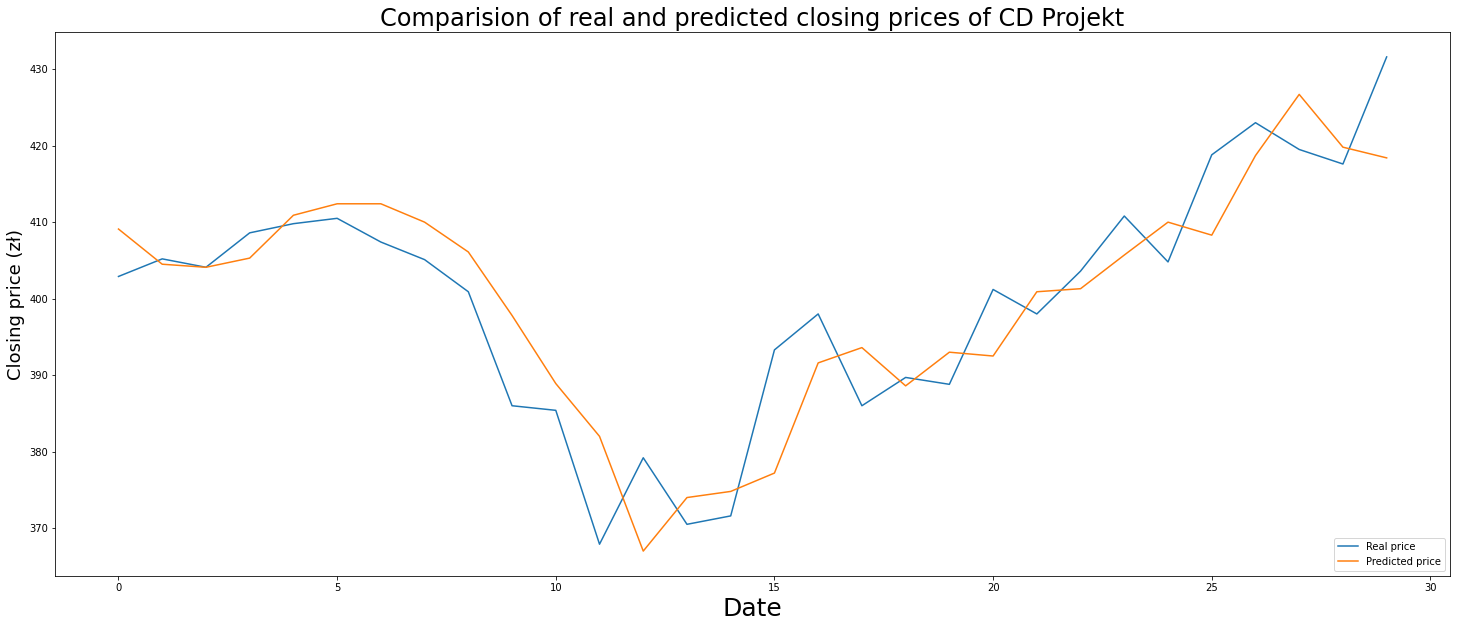

In [228]:
closing_prices = scaler.inverse_transform(dataset)[-30:,1]

predicted_closing_prices = np.round(predictions[:, 1], 1)

plt.figure(figsize=(25,10))
plt.title('Comparision of real and predicted closing prices of CD Projekt', fontsize=24)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Closing price (zł)', fontsize=18)
plt.plot(closing_prices)
plt.plot(predicted_closing_prices)
plt.legend(['Real price',  'Predicted price'], loc='lower right')
plt.show()

# Conclusion:

A single company data is not enough for getting useful predictions from neural network, although, considering small amount of training data, the results are pretty accurate (very close to naive prediction).

Training the neural network on more data (using more companies' data) and using more input features like indicators of technical or fundamental analysis and maybe some external factors might make predictions much better and useful in real world applications.

# Adding technical indicators to the neural network

In [229]:
daily_data.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1994-08-02,8.2789,8.2789,8.2789,8.2789,347109.0
1,1994-08-03,9.0931,9.0931,9.0931,9.0931,325196.0
2,1994-08-04,9.9950,9.9950,9.9950,9.9950,355499.0
3,1994-08-08,9.0931,9.0931,9.0931,9.0931,263619.0
4,1994-08-09,10.7320,10.7320,10.7320,10.7320,135441.0


**Moving averages on closing prices for periods of 10, 30 and 60 days**

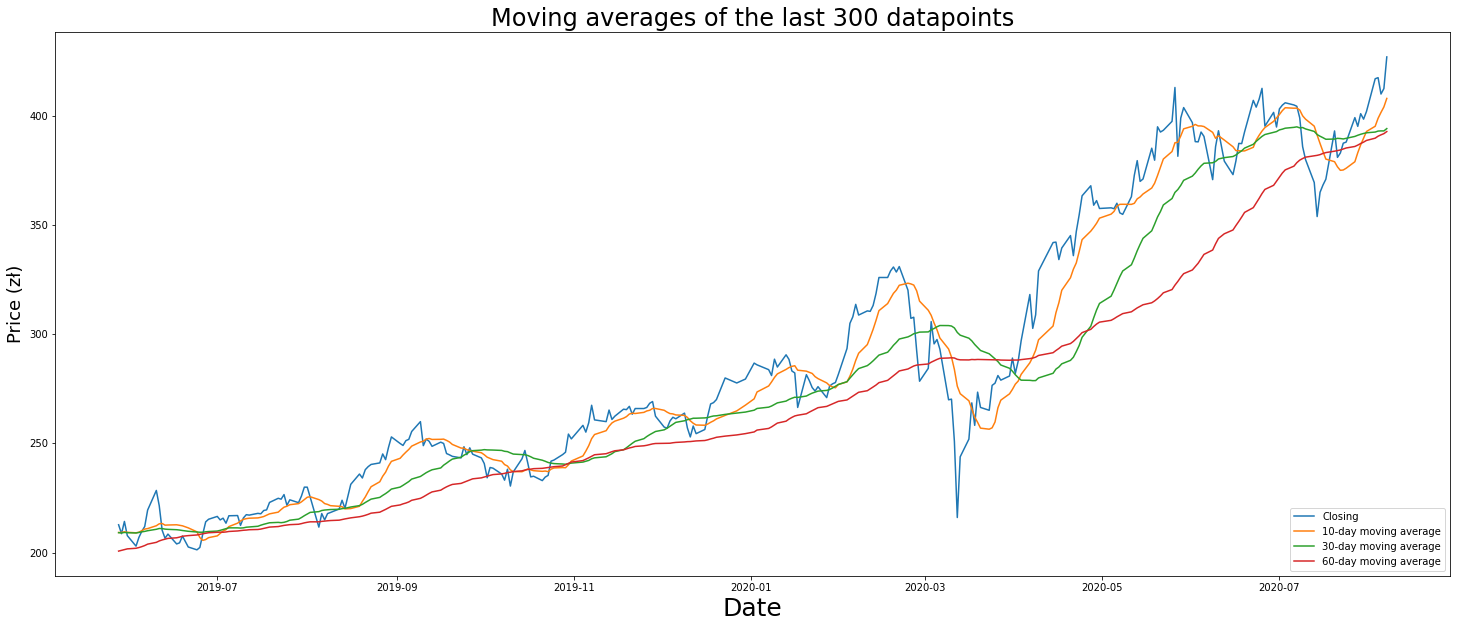

In [230]:

daily_data['MovingAverage10'] = daily_data['Zamkniecie'].rolling(10).mean()
daily_data['MovingAverage30'] = daily_data['Zamkniecie'].rolling(30).mean()
daily_data['MovingAverage60'] = daily_data['Zamkniecie'].rolling(60).mean()

datapoints_to_show = 300

plt.figure(figsize=(25,10))
plt.plot(daily_data['Data'].tail(datapoints_to_show), daily_data[['Zamkniecie', 'MovingAverage10', 'MovingAverage30', 'MovingAverage60']].tail(datapoints_to_show))
plt.title('Moving averages of the last ' + str(datapoints_to_show) + ' datapoints', fontsize=24)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Price (zł)', fontsize=18)
plt.legend(['Closing',  '10-day moving average',  '30-day moving average',  '60-day moving average'], loc='lower right')

**RSI**

In [231]:
period = 10
increase_diffrence, decrease_diffrence = daily_data['Zamkniecie'].diff(), daily_data['Zamkniecie'].diff()

increase_diffrence[increase_diffrence < 0] = 0
decrease_diffrence[decrease_diffrence > 0] = 0
# calculating EWMA (exponential moving average)
roll_increase = increase_diffrence.ewm(span = period).mean()
roll_decrease = decrease_diffrence.abs().ewm(span = period).mean()

RS = roll_increase / roll_decrease

RSI = 100 - (100 / (1 + RS))

daily_data['RSI'] = RSI

Text(0, 0.5, 'RSI')

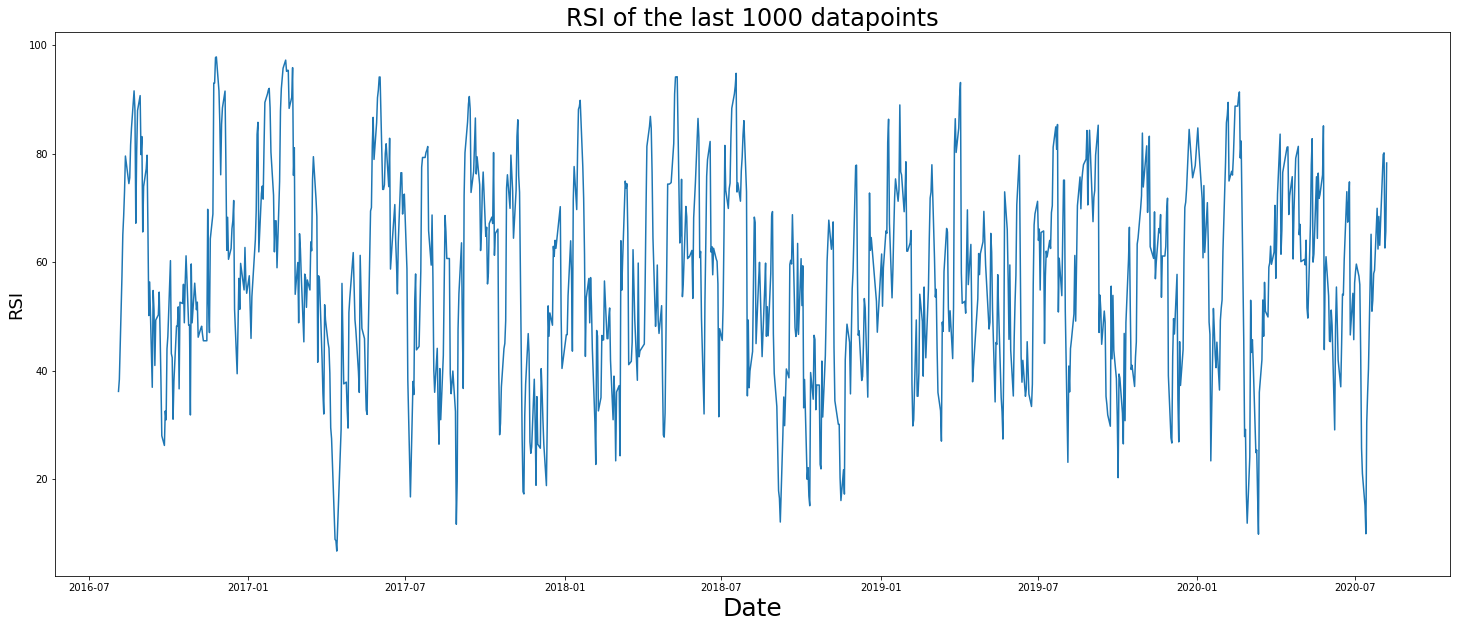

In [232]:
datapoints_to_show = 1000
plt.figure(figsize=(25,10))
plt.plot(daily_data['Data'].tail(datapoints_to_show), daily_data['RSI'].tail(datapoints_to_show))
plt.title('RSI of the last ' + str(datapoints_to_show) + ' datapoints', fontsize=24)
plt.xlabel('Date', fontsize=25)
plt.ylabel('RSI', fontsize=18)


**Rate of Change (ROC)**

In [233]:
daily_data['ROC'] = daily_data['Zamkniecie'].pct_change()

**Stochastic oscillator**

K = (C - L14)/(H14 - L14)

Where 
* C - closing price,
* L14 - lowest closing price from previous 14 sessions, 
* H14 - highest closing price from previous closing sessions

D - moving average of the stochastic oscillator K

In [234]:
window_size = 14
D_window_size = 4
L14, H14 = daily_data['Zamkniecie'].rolling(window_size).min(), daily_data['Zamkniecie'].rolling(window_size).max()

daily_data['K'] = (daily_data['Zamkniecie'] - L14)/(H14 - L14)
daily_data['D'] = daily_data['K'].rolling(D_window_size).mean()

**MACD, MACD Signal Line, their difference and Price Oscillator**

In [235]:
# 12 period moving average
EMA_26 = daily_data['Zamkniecie'].ewm(26).mean()
EMA_12 = daily_data['Zamkniecie'].ewm(12).mean()


daily_data['MACD'] = EMA_12 - EMA_26

daily_data['MACD_Signal'] = daily_data['MACD'].ewm(9).mean()

daily_data['MACD_Histogram'] = daily_data['MACD'] - daily_data['MACD_Signal']

daily_data['PPO'] =(EMA_12 - EMA_26)/EMA_26

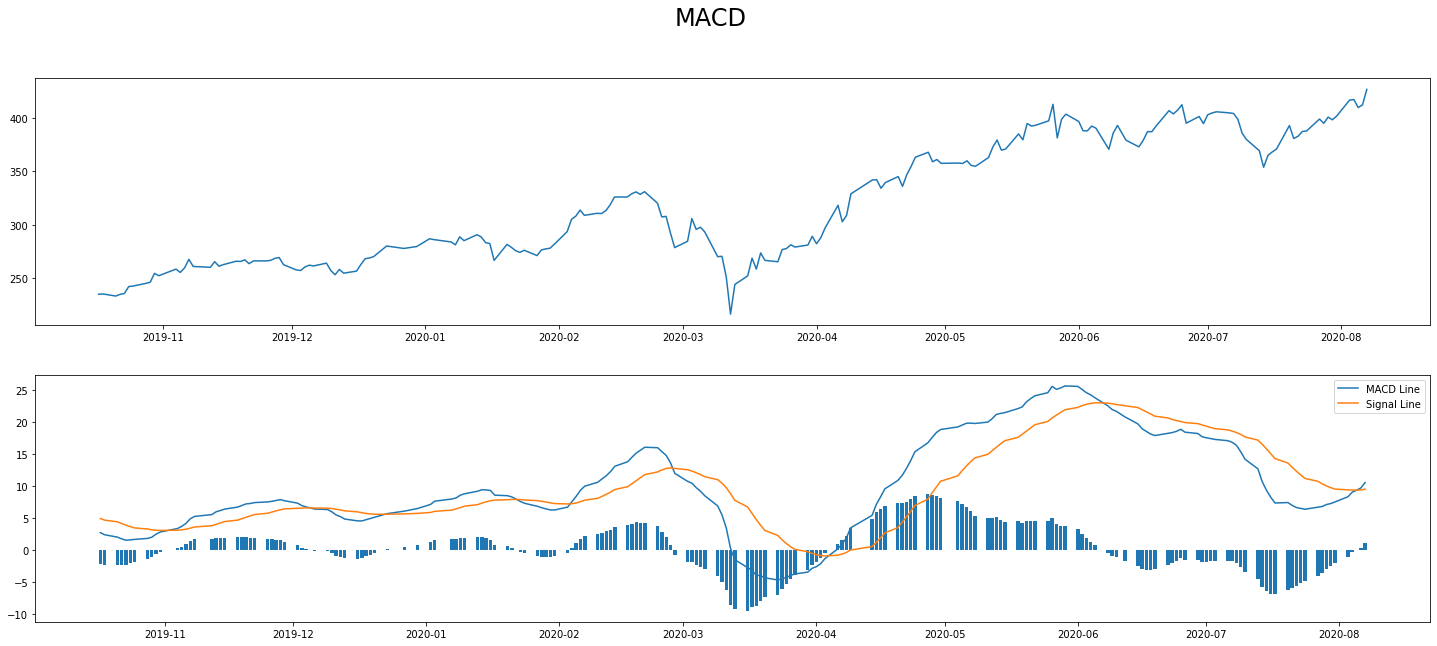

In [236]:
datapoints_to_show = 200 

fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(25,10)
#plt.figure(figsize=(25,10))
fig.suptitle('MACD', fontsize=24)

ax1.plot(daily_data['Data'].tail(datapoints_to_show), daily_data['Zamkniecie'].tail(datapoints_to_show))
ax2.plot(daily_data['Data'].tail(datapoints_to_show), daily_data[['MACD', 'MACD_Signal']].tail(datapoints_to_show))
ax2.bar(daily_data['Data'].tail(datapoints_to_show), daily_data['MACD_Histogram'].tail(datapoints_to_show))

ax2.legend(['MACD Line', 'Signal Line'])

**Triple Exponential Moving Average TEMA**

In [237]:
window_size = 10

SEMA = daily_data['Zamkniecie'].ewm(window_size).mean()
DEMA = SEMA.ewm(window_size).mean()
daily_data['TEMA'] = DEMA.ewm(window_size).mean()

**Commodity Channel Index CCI**

In [238]:
window_size = 20
typical_price = (daily_data['Najwyzszy'] + daily_data['Najnizszy'] + daily_data['Zamkniecie']) / 3
MA = typical_price.rolling(window_size).mean()
mean_deviation = (MA - typical_price).abs().rolling(window_size).mean()

daily_data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)

**Williams Percent Range**

In [239]:
window_size = 14
daily_data['Percent_Range'] = (daily_data['Najwyzszy'].rolling(window_size).max() - daily_data['Zamkniecie']) / (daily_data['Najwyzszy'].rolling(window_size).max() - daily_data['Najnizszy'].rolling(window_size).min())

In [240]:
daily_data.head(60)

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,MovingAverage10,MovingAverage30,MovingAverage60,RSI,ROC,K,D,MACD,MACD_Signal,MACD_Histogram,PPO,TEMA,CCI,Percent_Range
0,1994-08-02,8.2789,8.2789,8.2789,8.2789,347109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,8.278900,NaN,NaN
1,1994-08-03,9.0931,9.0931,9.0931,9.0931,325196.0,NaN,NaN,NaN,100.000000,0.098346,NaN,NaN,0.008603,0.004528,0.004075,0.000990,8.395918,NaN,NaN
2,1994-08-04,9.9950,9.9950,9.9950,9.9950,355499.0,NaN,NaN,NaN,100.000000,0.099185,NaN,NaN,0.024179,0.011779,0.012400,0.002644,8.524944,NaN,NaN
3,1994-08-08,9.0931,9.0931,9.0931,9.0931,263619.0,NaN,NaN,NaN,58.720489,-0.090235,NaN,NaN,0.016555,0.013168,0.003387,0.001813,8.622388,NaN,NaN
4,1994-08-09,10.7320,10.7320,10.7320,10.7320,135441.0,NaN,NaN,NaN,78.464461,0.180236,NaN,NaN,0.041283,0.020033,0.021250,0.004357,8.718852,NaN,NaN
5,1994-08-10,10.1230,10.1230,10.1230,10.1230,156263.0,NaN,NaN,NaN,64.461619,-0.056746,NaN,NaN,0.045210,0.025407,0.019803,0.004712,8.810142,NaN,NaN
6,1994-08-11,9.9170,9.9170,9.9170,9.9170,127846.0,NaN,NaN,NaN,60.032382,-0.020350,NaN,NaN,0.043501,0.028875,0.014626,0.004510,8.893861,NaN,NaN
7,1994-08-16,10.5360,10.5360,10.5360,10.5360,81439.0,NaN,NaN,NaN,68.085874,0.062418,NaN,NaN,0.054725,0.033414,0.021312,0.005600,8.973045,NaN,NaN
8,1994-08-17,11.0650,11.0650,11.0650,11.0650,82459.0,NaN,NaN,NaN,73.634941,0.050209,NaN,NaN,0.073959,0.040033,0.033927,0.007442,9.050833,NaN,NaN
9,1994-08-18,9.9560,9.9560,9.9560,9.9560,54547.0,9.87891,NaN,NaN,50.940256,-0.100226,NaN,NaN,0.064020,0.043715,0.020304,0.006440,9.124494,NaN,NaN


**Preprocess new data**

In [241]:
# drop first 60 rows so all columns have not null data
ta_training_set = daily_data.drop(columns=['Data'])[59:]
ta_dataset, ta_scaler = preprocess_scaled_data(ta_training_set)

In [242]:
#check dataset for nulls
np.argwhere(np.isnan(ta_dataset))

array([], shape=(0, 2), dtype=int64)

In [243]:
print('dataset shape: ' + str(ta_dataset.shape))

# using data from last 30 days for validation, rest for training
training_data = ta_dataset[:-30,:]

x_train = []
y_train = []
x_valid = []
y_valid = []

# predicting prices from data from last 60 days
for i in range(60, training_data.shape[0]):
  x_train.append(training_data[i-60:i, :])
  y_train.append(training_data[i,:])

x_train, y_train = np.array(x_train), np.array(y_train)

print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))

for i in range(ta_dataset.shape[0] - 30, ta_dataset.shape[0]):
  x_valid.append(ta_dataset[i-60:i, :])
  y_valid.append(ta_dataset[i,:])

x_valid, y_valid = np.array(x_valid), np.array(y_valid)

print('x_valid shape: ' + str(x_valid.shape))
print('y_valid shape: ' + str(y_valid.shape))

dataset shape: (6397, 19)
x_train shape: (6307, 60, 19)
y_train shape: (6307, 19)
x_valid shape: (30, 60, 19)
y_valid shape: (30, 19)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 64)                21504     
_________________________________________________________________
dense_28 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_29 (Dense)             (None, 19)                209       
Total params: 22,363
Trainable params: 22,363
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
198/198 [==============================] - 3s 6ms/step - loss: 0.0508 - val_loss: 0.0364
Epoch 2/30
198/198 [==============================] - 1s 4ms/step - loss: 0.0088 - val_loss: 0.0129
Epoch 3/30
198/198 [==============================] - 1s 4ms/step - loss: 0.0058 - val_loss: 0.0070
Epoch 4/30
198/198 [==============================] - 1s 5ms/step - loss: 0.005

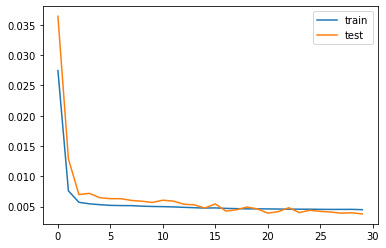

In [244]:
model = Sequential()
model.add(LSTM(64, input_shape=[x_train.shape[1], x_train.shape[2]]))#, return_sequences=True))

#model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Dense(x_train.shape[2]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [245]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model.  Made on the last 30 days of the stock data

predictions = model.predict(x_valid)
predictions = ta_scaler.inverse_transform(predictions)

mae = np.mean(np.abs((predictions[:,1] - ta_scaler.inverse_transform(y_valid)[:,1])))
naive_forcast_difference = [abs(ta_scaler.inverse_transform(y_valid)[i + 1,1] - ta_scaler.inverse_transform(y_valid)[i,1]) for i in range(y_valid.shape[0] - 1)]
naive_forcast_mae = sum(naive_forcast_difference) / len(naive_forcast_difference)
mape = np.mean((np.abs((predictions[:,1] - ta_scaler.inverse_transform(y_valid)[:,1]))/ta_scaler.inverse_transform(y_valid)[:,1])*100)
naive_forcast_mape = (naive_forcast_mae/ta_scaler.inverse_transform(y_valid)[:,1].mean()) * 100

print('Prediction mean absolute error: ' + str(mae))
print('Naive forcast mean absolute error: ' + str(naive_forcast_mae))

print('Prediction mean absolute percentage error: ' + str(mape))
print('Naive forcast mean absolute percentage error: ' + str(naive_forcast_mape))

Prediction mean absolute error: 8.033037109375
Naive forcast mean absolute error: 6.4999999999999964
Prediction mean absolute percentage error: 2.0171421592732894
Naive forcast mean absolute percentage error: 1.6250270837847292


In [246]:
# Comparision of the closing stock prices
inversed_dataset = scaler.inverse_transform(dataset)
print('Ceny zamknięcia: Przewidywana/Rzeczywista/Różnica')
closing_prices = daily_data['Zamkniecie']
for i in range(predictions.shape[0]):
  print(str(round(predictions[i, 1], 1)) + ' / ' + str(daily_data['Zamkniecie'].iloc[-30 + i]) + ' / ' + str(round(predictions[i, 1] - daily_data['Zamkniecie'].iloc[-30 + i], 1)))

Ceny zamknięcia: Przewidywana/Rzeczywista/Różnica
413.3 / 401.6 / 11.7
417.3 / 394.9 / 22.4
412.2 / 403.2 / 9.0
416.0 / 404.9 / 11.1
416.6 / 406.0 / 10.6
418.6 / 405.0 / 13.6
419.8 / 404.4 / 15.4
419.6 / 399.1 / 20.5
415.4 / 385.9 / 29.5
403.1 / 380.0 / 23.1
395.9 / 369.5 / 26.4
385.4 / 353.9 / 31.5
371.5 / 365.0 / 6.5
377.4 / 368.3 / 9.1
374.4 / 371.0 / 3.4
375.3 / 393.1 / -17.8
389.2 / 381.0 / 8.2
385.8 / 383.0 / 2.8
389.5 / 387.5 / 2.0
393.0 / 388.0 / 5.0
392.5 / 399.2 / -6.7
400.1 / 395.2 / 4.9
398.4 / 401.0 / -2.6
404.4 / 398.5 / 5.9
406.3 / 402.0 / 4.3
408.4 / 417.0 / -8.6
415.9 / 417.5 / -1.6
420.8 / 410.0 / 10.8
418.4 / 412.5 / 5.9
422.4 / 427.0 / -4.6


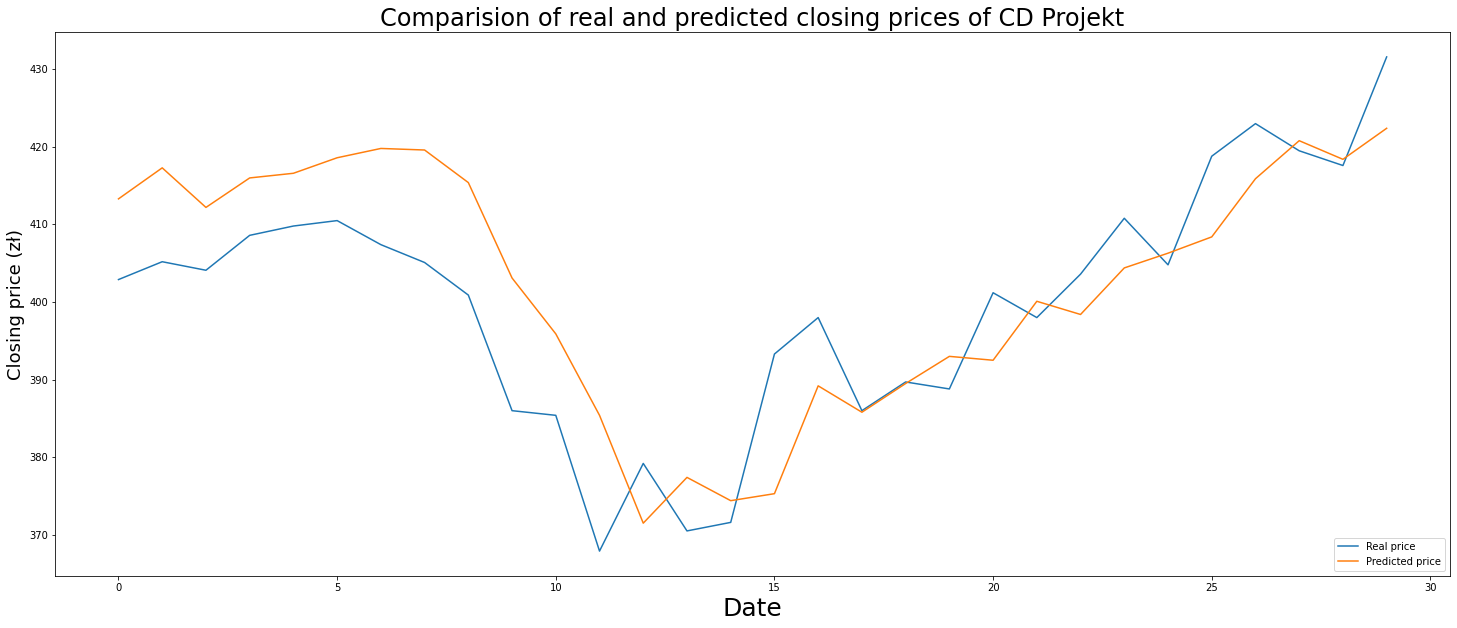

In [247]:
closing_prices = scaler.inverse_transform(dataset)[-30:,1]

predicted_closing_prices = np.round(predictions[:, 1], 1)

plt.figure(figsize=(25,10))
plt.title('Comparision of real and predicted closing prices of CD Projekt', fontsize=24)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Closing price (zł)', fontsize=18)
plt.plot(closing_prices)
plt.plot(predicted_closing_prices)
plt.legend(['Real price',  'Predicted price'], loc='lower right')
plt.show()